In [1]:
import seaborn as sns
import spacy
import nltk
from nltk import bigrams
#from nltk.corpus import stopwords
import pandas as pd
import itertools
import collections
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from textblob import TextBlob
import numpy as np
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import datetime
import matplotlib.dates as mdates 

In [2]:
# input tweets from pickle file (They have been cleaned allready)
tweets = pd.read_pickle("/Users/tomashegewisch/Desktop/all_6_months_2.pkl")
d1 = "2020-03-01"
d2 = "2020-08-31"
def get_date_range_for_tweet(date):
    date_1 = datetime.datetime.strptime(d1,'%Y-%m-%d')
    date_2 = datetime.datetime.strptime(d2,'%Y-%m-%d')
    date = date.to_pydatetime().strftime("%Y-%m-%d")
    date = datetime.datetime.strptime(date,'%Y-%m-%d')
    if date >= date_1 and date <= date_2:
        return True
    else:
        return False
# Remove tweets that are out of the date range 
tweets = tweets[tweets['date'].apply(lambda x : get_date_range_for_tweet(x)) == True]

In [3]:
# Create a dataframe from all the words that have been tokenised
word_list = [] 
for i in tweets['tokenised']:
    for j in i:
        if j != "amp":
            word_list.append(j)
word_list = pd.DataFrame(word_list)

In [4]:
#This is no-longer used
# # Process a Sentimnet value for each tweet.
# def get_sent(text):
#     return TextBlob(text).sentiment.polarity

# tweets['senti_values'] = tweets['tweet_clean'].apply(lambda x : get_sent(x))

In [5]:
# sentimnet score was crected by Richards using https://stanfordnlp.github.io/stanza/sentiment.html
sentimnet_df = pd.read_csv('/Users/tomashegewisch/research_project/Tomas/data/sentiment.csv') 
tweets = pd.merge(tweets, sentimnet_df, on="id")
tweets = tweets.rename(columns={'sentiment': 'senti_values'})

In [8]:
# Create bar chart showing Sentimnet for the top 10 most common words.
word_list_counter = Counter(word_list[0])
def get_sent_for_top_words(text, lookout_word):
    if lookout_word not in text:
        return None
    else:
        return TextBlob(text).sentiment.polarity

for i in word_list_counter.most_common(10):
    tweet_senti_values = tweets['tweet_clean'].apply(lambda x : get_sent_for_top_words(x, i[0]))
    tweet_senti_values = tweet_senti_values.dropna(axis=0, inplace=False, how=None)
    #tweet_senti_values.hist()
    plt.hist(tweet_senti_values)
    plt.title('Sentiment around the word: ' + i[0])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/barchart/barchart_Sentiment_"+i[0]+".png")
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [5]:
# Split positive and negitive tweets into two diffrent data frame columes.
def get_value_positive(x):
    if x > 0.0:
        return x
    else:
        return None

def get_value_negitive(x):
    if x < 0.0:
        return x
    else:
        return None
# we have removed the 0 from both.  
tweets["positve"] = tweets['senti_values'].apply(get_value_positive)
tweets["negitive"] = tweets['senti_values'].apply(get_value_negitive)

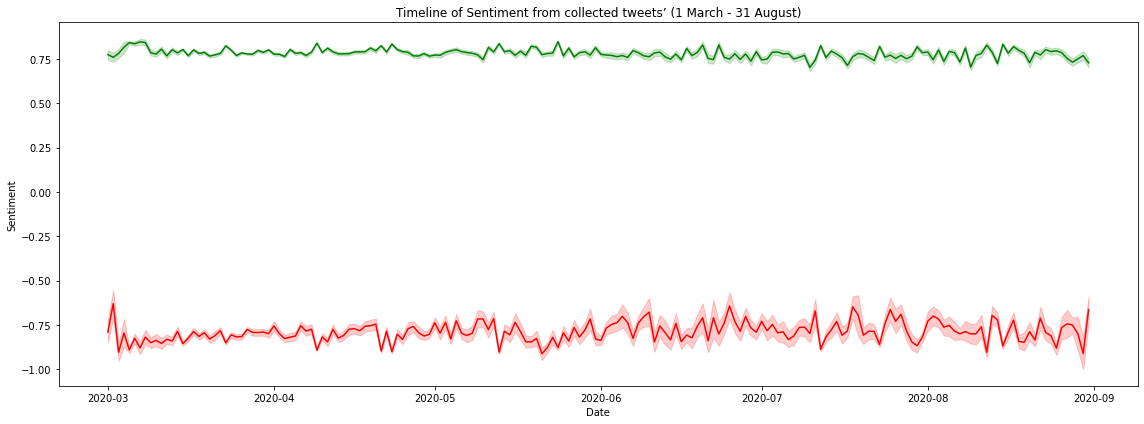

<Figure size 432x288 with 0 Axes>

In [6]:
# The entire sentimnet values for the 6 months.
tweets['sentiment_type'] = 'Neutral'
tweets.loc[tweets['senti_values'] > 0, 'sentiment_type'] = 'Positive'
tweets.loc[tweets['senti_values'] < 0, 'sentiment_type'] = 'Negative'
plt.figure(figsize=(16, 6))
sns.lineplot(data=tweets[tweets['sentiment_type'] != 'Neutral'].rename(columns={"senti_values": "Sentiment","date":"Date"}),
             x='Date',
             y='Sentiment',
             hue='sentiment_type', 
             palette=['green', 'red'], 
             legend=False, ci=68).set_title("Timeline of Sentiment from collected tweets’ (1 March - 31 August)").get_figure()
plt.tight_layout()
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/Sentiment_Timeline of sentiment from collected tweets.png")
plt.show()
plt.clf()

In [143]:
# def get_key_word(text, kw):
#     if kw in text:
#         return True
#     else:
#         return "no"
    
# # want to find the date range 
# def get_the_date(month_code):
#     moths_dates = {1:['2020-03-01','2020-03-31',"March"],
#                   2:['2020-04-01','2020-04-30', "April"],
#                   3:['2020-05-01','2020-05-31', "May"],
#                   4:['2020-06-01','2020-06-30', "June"],
#                   5:['2020-07-01','2020-07-31', "July"],
#                   6:['2020-08-01','2020-08-31', "August"],
#                   7:['2020-09-01','2020-09-30', "September"],
#                   8:['2020-10-01','2020-10-31', "October"]}
#     return moths_dates[month_code]

# # retrunr if the date is not in the rage
# def get_date_range(date, d1, d2):
#     date_1 = datetime.datetime.strptime(d1,'%Y-%m-%d')
#     date_2 = datetime.datetime.strptime(d2,'%Y-%m-%d')
#     date = date.to_pydatetime().strftime("%Y-%m-%d")
#     date = datetime.datetime.strptime(date,'%Y-%m-%d')
#     if date >= date_1 and date <= date_2:
#         return True
#     else:
#         return False
    
# # group by date

# for i in range(1,9):
#     nedded_dates = get_the_date(i)
#     for i in word_list_counter.most_common(1):
#         # select start and end date
#         # Drop The columes that do not include the key_word
#         key_word = i[0]
#         key_word_sentimnet_score_all = tweets[tweets['tweet'].apply(lambda x : get_key_word(x,key_word)) == True]
#         key_word_sentimnet_score_all = key_word_sentimnet_score_all[key_word_sentimnet_score_all['date'].apply(lambda x : get_date_range(x, nedded_dates[0], nedded_dates[1])) == True]
#         #Group by
#         positive_date_mean = key_word_sentimnet_score_all.groupby('date', as_index=False)['positve'].mean()
#         negitive_date_mean = key_word_sentimnet_score_all.groupby('date', as_index=False)['negitive'].mean()
#         # ASK RICH ABOUT THIS SECTION OF CODE>>> What it does is adds the prvious value to the NaN sections.
#         NaN_test = pd.isnull(positive_date_mean)
#         temp = 0.0 
#         for i in range(0, len(NaN_test)):
#             try:
#                 if NaN_test['positve'][i] == True:

#                     positive_date_mean['positve'][i] = temp
#                 else:
#                     temp = positive_date_mean['positve'][i]
#             except:
#                 continue
#         NaN_test = pd.isnull(negitive_date_mean)
#         temp = 0.0
#         for i in range(0, len(NaN_test)):
#             try:
#                 if NaN_test['negitive'][i] == True:
#                     negitive_date_mean['negitive'][i] = temp
#                 else:
#                     temp = negitive_date_mean['negitive'][i]
#             except:
#                 continue 

#         # Dsiplay The plot.
#         display_df_average = positive_date_mean
#         display_df_average['negitive'] = negitive_date_mean['negitive']
#         plt.figure(figsize=(16, 6))
#         sns.lineplot(x='Date', y='Polarity', hue='Key', 
#              data=pd.melt(display_df_average, ['date']).rename(columns={"value": "Polarity","variable":"Key", "date":"Date"})).set_title("The Sentiment for " + str(nedded_dates[2]) + " of Topic: "+key_word).get_figure().autofmt_xdate()
#         plt.tight_layout()
#         plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/line_sentiment/Sentiment_"+key_word+"_"+str(nedded_dates[2])+".png")
#         plt.show()
#         plt.clf()

In [8]:
# https://stackoverflow.com/a/1060330
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)

def build_dt(df):
    start_date = datetime.date(2020, 3, 1)
    end_date = datetime.date(2020, 9, 1)

    for date in daterange(start_date, end_date):
        yield date, sum(df['date'] == date.strftime("%Y-%m-%d"))
def build_dt1(df, ocol):
    start_date = datetime.date(2020, 3, 1)
    end_date = datetime.date(2020, 9, 1)

    for date in daterange(start_date, end_date):
        try:
            yield date, sum(df.loc[df['date'] == date.strftime("%Y-%m-%d"), ocol]) / sum(df['date'] == date.strftime("%Y-%m-%d"))
        except:
            yield date, 0
# sns.lineplot(data=pd.DataFrame(build_dt(tweets), columns=['date', 'count']), x='date', y='count')

53.7154420045044


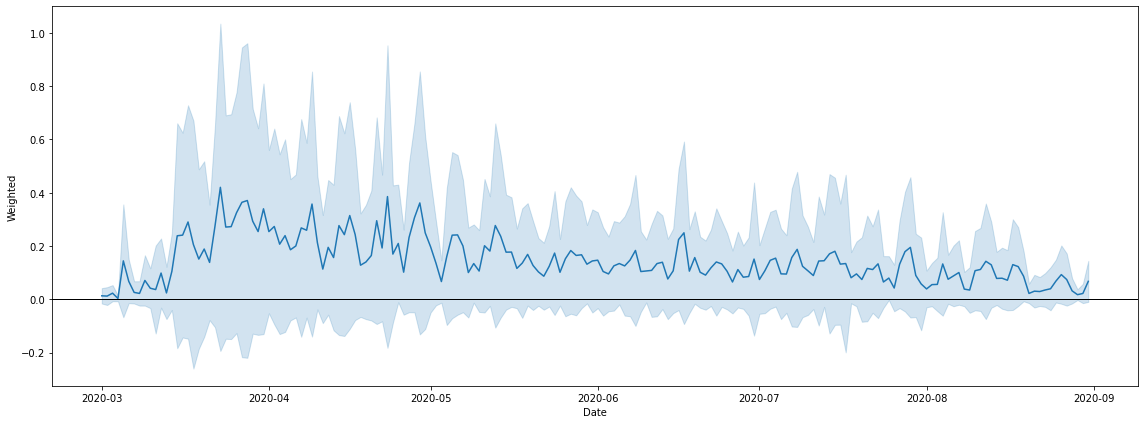

<class 'matplotlib.axes._subplots.AxesSubplot'>
68.31332615294228


<Figure size 432x288 with 0 Axes>

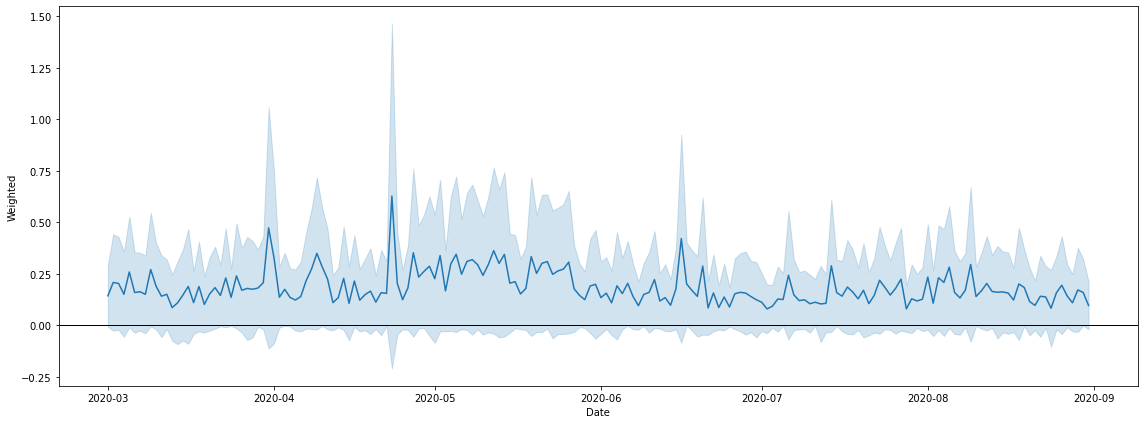

<class 'matplotlib.axes._subplots.AxesSubplot'>
57.3442115292997


<Figure size 432x288 with 0 Axes>

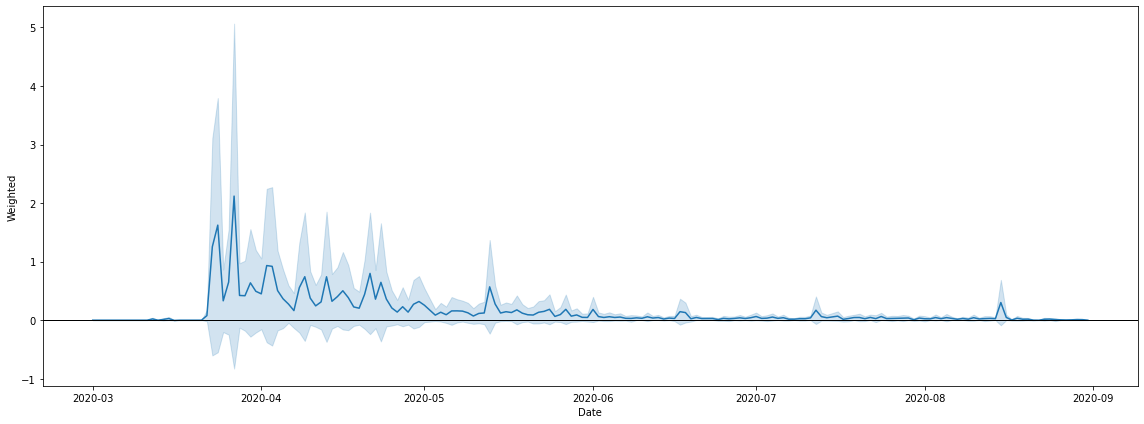

<class 'matplotlib.axes._subplots.AxesSubplot'>
49.45454545454553


<Figure size 432x288 with 0 Axes>

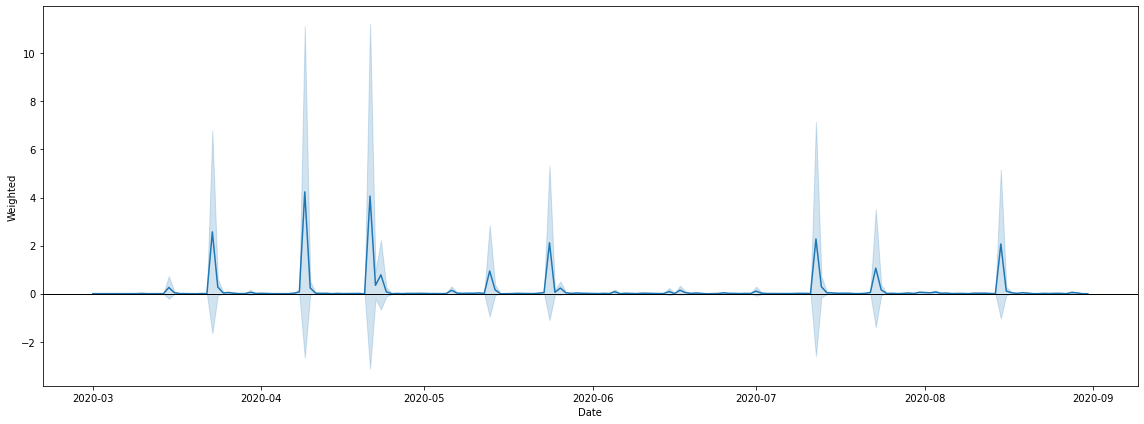

<class 'matplotlib.axes._subplots.AxesSubplot'>
57.82840236686391


<Figure size 432x288 with 0 Axes>

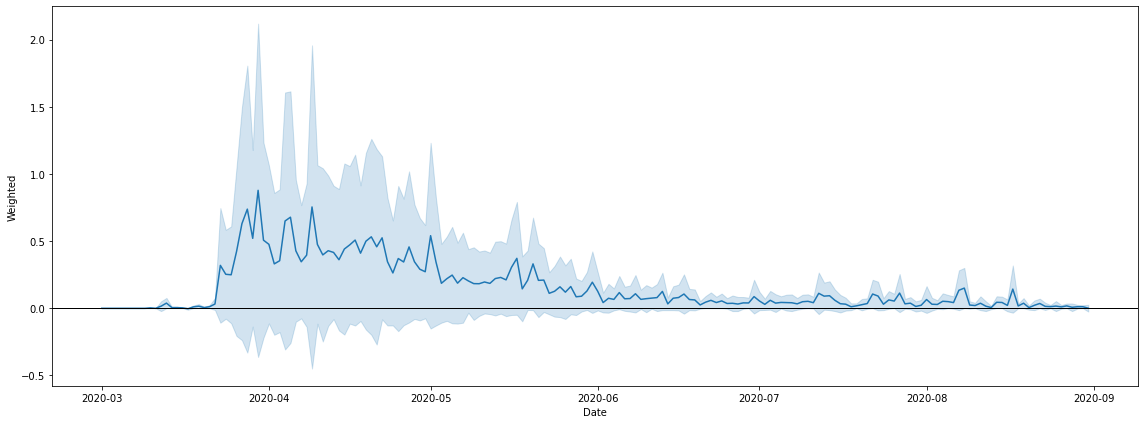

<class 'matplotlib.axes._subplots.AxesSubplot'>
56.86135936030109


<Figure size 432x288 with 0 Axes>

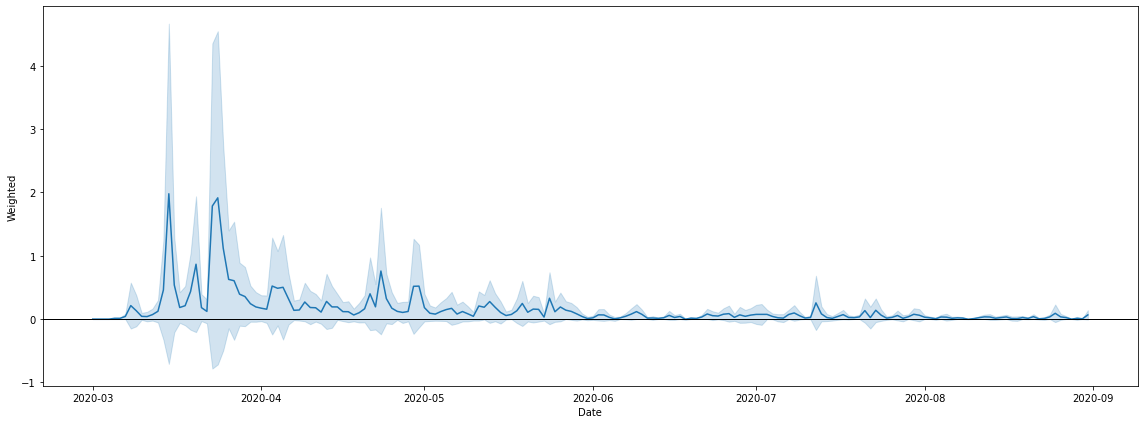

<class 'matplotlib.axes._subplots.AxesSubplot'>
57.63983953867366


<Figure size 432x288 with 0 Axes>

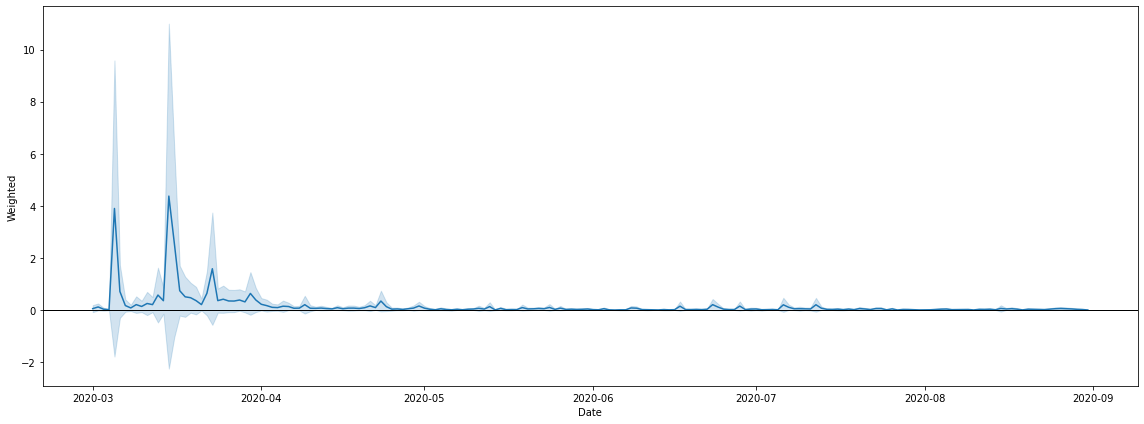

<class 'matplotlib.axes._subplots.AxesSubplot'>
54.2492478941035


<Figure size 432x288 with 0 Axes>

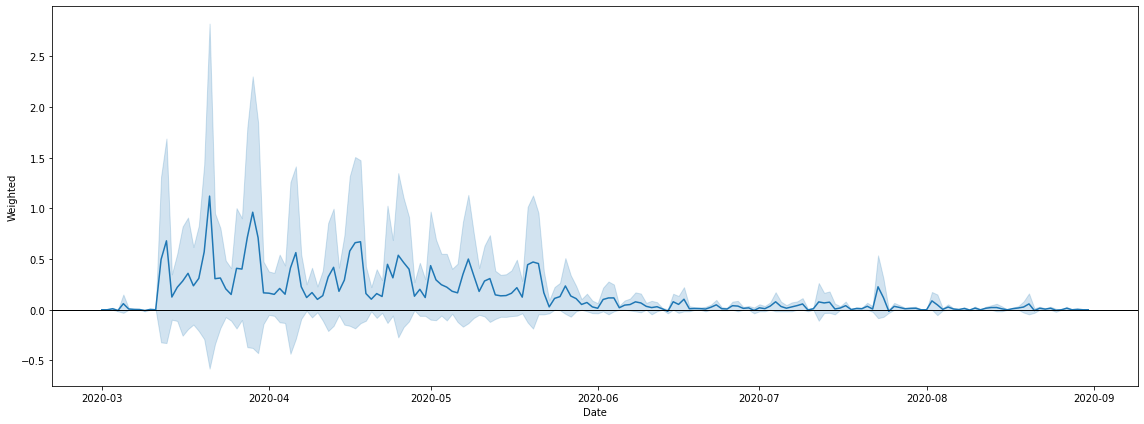

<class 'matplotlib.axes._subplots.AxesSubplot'>
59.60262371305216


<Figure size 432x288 with 0 Axes>

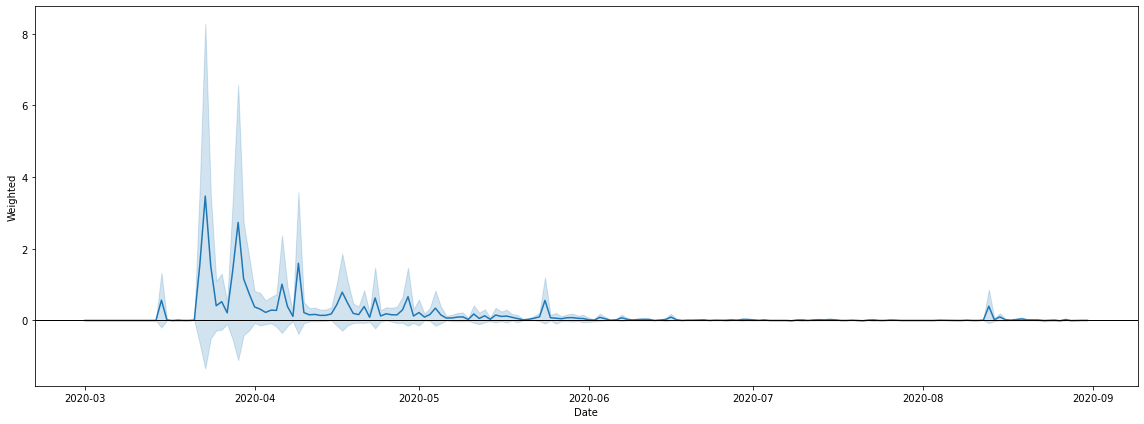

<class 'matplotlib.axes._subplots.AxesSubplot'>
41.63265306122452


<Figure size 432x288 with 0 Axes>

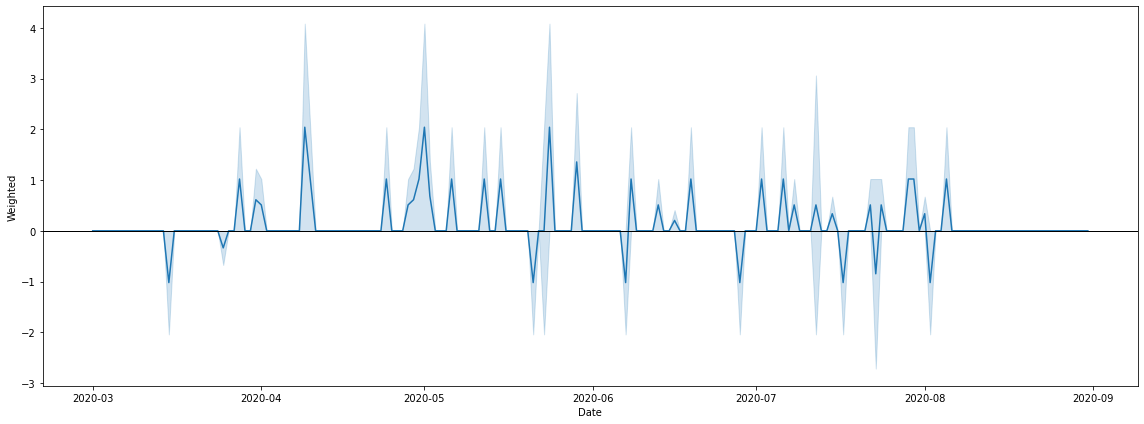

<class 'matplotlib.axes._subplots.AxesSubplot'>


<Figure size 432x288 with 0 Axes>

In [9]:
def hashtags(hashtag):
    tweetsl = tweets[tweets['hashtags'].apply(lambda x: hashtag in x)]
    ps = pd.DataFrame(build_dt1(tweetsl[tweetsl['sentiment_type'] == 'Positive'], 'senti_values'), columns=['date', 'senti_values'])
    ps['count'] = pd.DataFrame(build_dt(tweetsl[tweetsl['sentiment_type'] == 'Positive']), columns=['date', 'count'])['count']
    ptotal = sum(ps['count'])
    ps['type'] = 'Positive'

    ns = pd.DataFrame(build_dt1(tweetsl[tweetsl['sentiment_type'] == 'Negative'], 'senti_values'), columns=['date', 'senti_values'])
    ns['count'] = pd.DataFrame(build_dt(tweetsl[tweetsl['sentiment_type'] == 'Negative']), columns=['date', 'count'])['count']
    ntotal = sum(ns['count'])
    ns['type'] = 'Negative'

#     ps['weighted'] = ps['sentiment'] * (ps['count'] / (ptotal + ntotal)) * 100
#     ns['weighted'] = ns['sentiment'] * (ns['count'] / (ptotal + ntotal)) * 100
#     print(sum((ps['count'] / (ptotal + ntotal)) * 100))

    sent_combined = ps.append(ns)
#     print(sent_combined[sent_combined['weighted'] > 1])
    sent_combined['weighted'] = sent_combined['senti_values'] * (sent_combined['count'] / sum(sent_combined['count']) * 100)
    print(sum(sent_combined['weighted']))
    plt.figure(figsize=(16, 6))
    p = sns.lineplot(data=sent_combined.rename(columns={"weighted": "Weighted","date":"Date"}), 
                     x='Date', 
                     y='Weighted')#, hue='type')
    p.axhline(0, color='black', lw=1)
#     sns.lineplot(x='Date',
#                  y='Polarity',
#                  hue='Key',
#                  data=pd.melt(display_df_average, 
#                               ['date']).rename(columns={"value": "Polarity","variable":"Key", "date":"Date"})).set_title("The Sentiment for of Topic: "+key_word).get_figure().autofmt_xdate()
    plt.tight_layout()
    plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/hastag_sentiment/hastag_Sentiment_"+hashtag+"_AllMonths.png")
    plt.show()
    plt.clf()
    
    
    print(type(p))
    
list_of_hastages_to_process = ['covid19', 
'southafrica', 
'lockdownsa', 
'cyrilramaphosa', 
'lockdown', 
'covid19sa',
'coronavirussa',
'covid_19', 
'lockdownsouthafrica',
'government']

# list_of_hastages_to_process = ['southafrica']
for i in list_of_hastages_to_process:
    hashtags(i)

<ipython-input-10-2af517f15f30>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_date_mean['positve'][i] = temp
<ipython-input-10-2af517f15f30>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negitive_date_mean['negitive'][i] = temp


['2020-03-01', '2020-08-31']


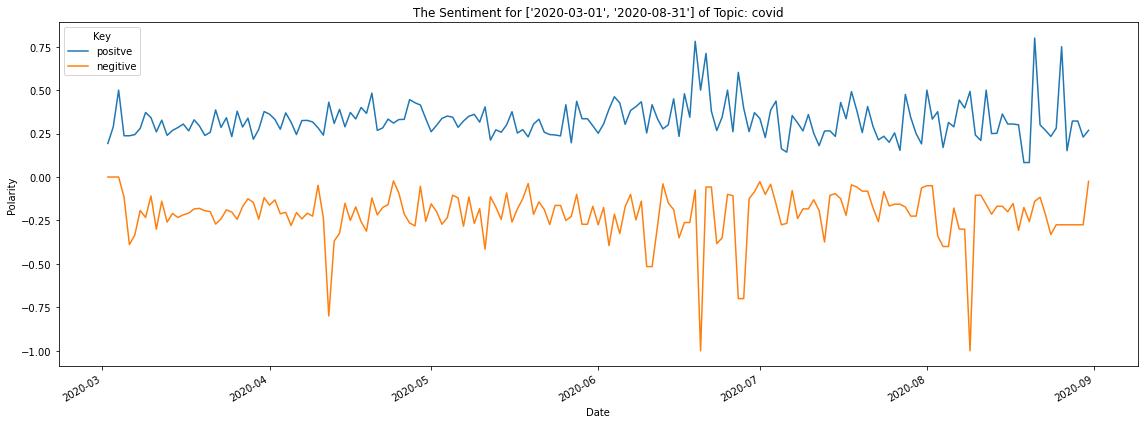

<Figure size 432x288 with 0 Axes>

In [10]:
#drill down code
def drill_down_date_topic(topic_word, date_1, date_2):
    key_word = topic_word
    nedded_dates = [date_1, date_2]
    key_word_sentimnet_score_all = tweets[tweets['tweet'].apply(lambda x : get_key_word(x,key_word)) == True]
    key_word_sentimnet_score_all = key_word_sentimnet_score_all[key_word_sentimnet_score_all['date'].apply(lambda x : get_date_range(x, nedded_dates[0], nedded_dates[1])) == True]
    positive_date_mean = key_word_sentimnet_score_all.groupby('date', as_index=False)['positve'].mean()
    negitive_date_mean = key_word_sentimnet_score_all.groupby('date', as_index=False)['negitive'].mean()
    # ASK RICH ABOUT THIS SECTION OF CODE>>> What it does is adds the prvious value to the NaN sections.
    NaN_test = pd.isnull(positive_date_mean)
    temp = 0.0 
    for i in range(0, len(NaN_test)):
        try:
            if NaN_test['positve'][i] == True:
                positive_date_mean['positve'][i] = temp
            else:
                temp = positive_date_mean['positve'][i]
        except:
            continue
    NaN_test = pd.isnull(negitive_date_mean)
    temp = 0.0
    for i in range(0, len(NaN_test)):
        try:
            if NaN_test['negitive'][i] == True:
                negitive_date_mean['negitive'][i] = temp
            else:
                temp = negitive_date_mean['negitive'][i]
        except:
            continue 

        # Dsiplay The files.
    display_df_average = positive_date_mean
    display_df_average['negitive'] = negitive_date_mean['negitive']
    plt.figure(figsize=(16, 6))
    sns.lineplot(x='Date',
                 y='Polarity',
                 hue='Key',
                 data=pd.melt(display_df_average, 
                              ['date']).rename(columns={"value": "Polarity","variable":"Key", "date":"Date"})).set_title("The Sentiment for " + str(nedded_dates) + " of Topic: "+key_word).get_figure().autofmt_xdate()
    plt.tight_layout()
    print(nedded_dates)
    plt.show()
    #plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/Sentiment_"+key_word+"_"+str(nedded_dates[0])+"_"+str(nedded_dates[1])+".png")
    plt.clf()

drill_down_date_topic("covid", '2020-03-01', '2020-08-31')

In [13]:
# # get sentimnet for 6 months of a particular "hashtag"
# def get_if_hastag(htags_list):
#     for i in htags_list:
#         if i == find_word:
#             return True
#     return False
# def drill_down_date_hastage(topic_word):
#     key_word = topic_word
#     key_word_sentimnet_score_all = tweets[tweets['hashtags'].apply(lambda x : get_key_word(x,key_word)) == True]
#     positive_date_mean = key_word_sentimnet_score_all.groupby('date', as_index=False)['positve'].mean()
#     negitive_date_mean = key_word_sentimnet_score_all.groupby('date', as_index=False)['negitive'].mean()
#     # ASK RICH ABOUT THIS SECTION OF CODE>>> What it does is adds the prvious value to the NaN sections.
#     NaN_test = pd.isnull(positive_date_mean)
#     temp = 0.0 
#     for i in range(0, len(NaN_test)):
#         try:
#             if NaN_test['positve'][i] == True:
#                 positive_date_mean['positve'][i] = temp
#             else:
#                 temp = positive_date_mean['positve'][i]
#         except:
#             continue
#     NaN_test = pd.isnull(negitive_date_mean)
#     temp = 0.0
#     for i in range(0, len(NaN_test)):
#         try:
#             if NaN_test['negitive'][i] == True:
#                 negitive_date_mean['negitive'][i] = temp
#             else:
#                 temp = negitive_date_mean['negitive'][i]
#         except:
#             continue 

#         # Dsiplay The files.
#     display_df_average = positive_date_mean
#     display_df_average['negitive'] = negitive_date_mean['negitive']
#     plt.figure(figsize=(16, 6))
#     sns.lineplot(x='Date',
#                  y='Polarity',
#                  hue='Key',
#                  data=pd.melt(display_df_average, 
#                               ['date']).rename(columns={"value": "Polarity","variable":"Key", "date":"Date"})).set_title("The Sentiment for of Topic: "+key_word).get_figure().autofmt_xdate()
#     plt.tight_layout()
#     plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/hastag_sentiment/hastag_Sentiment_"+key_word+"_AllMonths_.png")
#     plt.show()
#     plt.clf()

# list_of_hastages_to_process = ['covid19', 
# 'southafrica', 
# 'lockdownsa', 
# 'cyrilramaphosa', 
# 'lockdown', 
# 'covid19sa',
# 'coronavirussa',
# 'covid_19', 
# 'lockdownsouthafrica',
# 'government']

# # list_of_hastages_to_process = ['southafrica']
# for i in list_of_hastages_to_process:
#     drill_down_date_hastage(i)

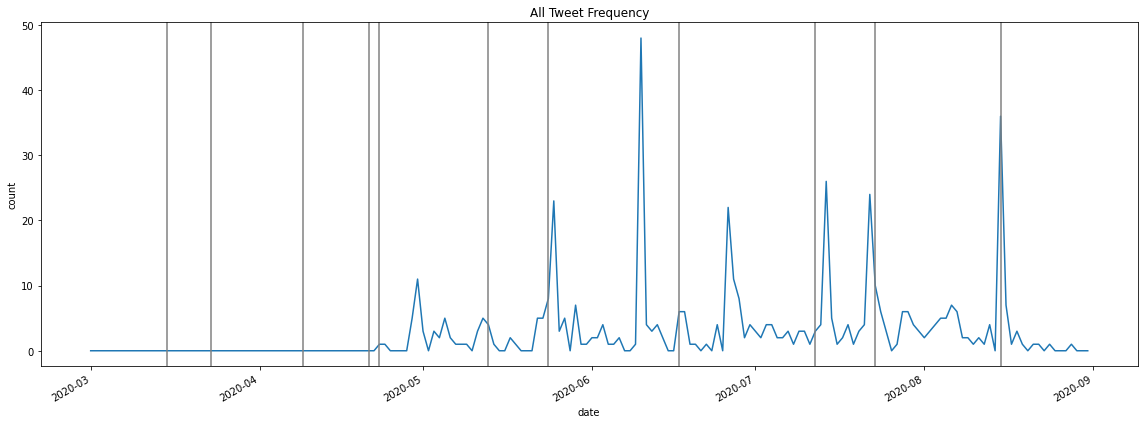

<Figure size 432x288 with 0 Axes>

In [33]:
#Frequency of posting
# https://stackoverflow.com/a/1060330
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)
def build_dt(df):
    start_date = datetime.date(2020, 3, 1)
    end_date = datetime.date(2020, 9, 1)
    for date in daterange(start_date, end_date):
        yield date, sum(df['date'] == date.strftime("%Y-%m-%d"))
        
#post_feq = tweets.groupby('date', as_index=False).size()
post_feq = pd.DataFrame(build_dt(tweets[tweets['hashtags'].apply(lambda x: 'cigaretteban' in x)]), columns=['date', 'count'])

plt.figure(figsize=(16, 6))
sns.lineplot(x='date',
                 y='count',
                 data=post_feq).set_title("All Tweet Frequency").get_figure().autofmt_xdate()
pres_speaks_dates =[
'2020-03-15',
'2020-03-23',
'2020-04-09',
'2020-04-21',
'2020-04-23',
'2020-05-13',
'2020-05-24',
'2020-06-17',
'2020-07-12',
'2020-07-23',
'2020-08-15']

for i in pres_speaks_dates:
    plt.axvline(i, c='grey')
    
plt.tight_layout()
plt.show()
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/Frequency/all_tweet_frequency.png")
plt.clf()

NameError: name 'find_word' is not defined

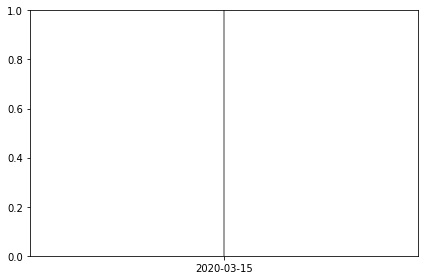

In [34]:
# plot the timeline frequency for popular hastags for the 6 months. 
def get_time_line_of_hastages(find_word):
    def get_if_hastag(htags_list):
        for i in htags_list:
            if i == find_word:
                return True
        return False
    specific_hastage_tweets = tweets[tweets['hashtags'].apply(lambda x : get_if_hastag(x)) == True]
    post_feq = pd.DataFrame(build_dt(specific_hastage_tweets), columns=['date', 'count'])
    
    plt.figure(figsize=(16, 6))
    sns.lineplot(x='date',
                 y='count',
                 data=post_feq).set_title("Frequency for: "+str(find_word)).get_figure().autofmt_xdate()
    pres_speaks_dates =[
    '2020-03-15',
    '2020-03-23',
    '2020-04-09',
    '2020-04-21',
    '2020-04-23',
    '2020-05-13',
    '2020-05-24',
    '2020-06-17',
    '2020-07-12',
    '2020-07-23',
    '2020-08-15']

for i in pres_speaks_dates:
    plt.axvline(i, c='grey')
    
    plt.tight_layout()
    print("/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_"+str(find_word)+".png")
    plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_"+str(find_word)+".png")
    plt.show()
    plt.clf()
    
list_of_hastages_to_process = ['covid19', 
'southafrica', 
'lockdownsa', 
'cyrilramaphosa', 
'lockdown', 
'covid19sa',
'coronavirussa',
'covid_19', 
'lockdownsouthafrica',
'government',
'cigaretteban', 
'alcoholban']

#list_of_hastages_to_process = ['lockdown']

for i in list_of_hastages_to_process:
    get_time_line_of_hastages(i)

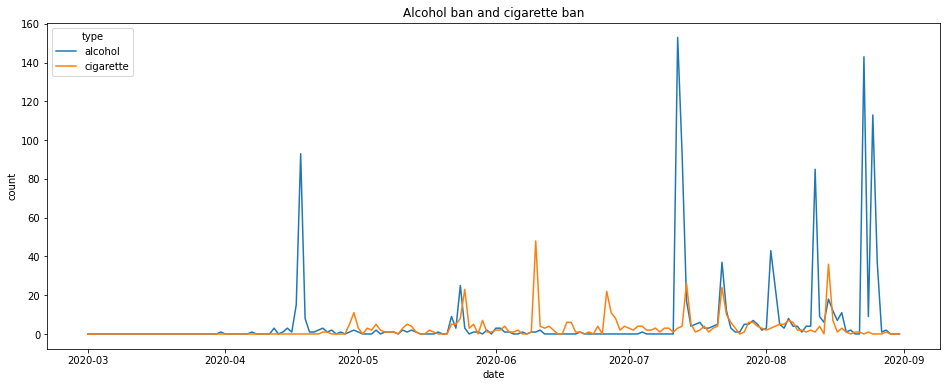

<Figure size 432x288 with 0 Axes>

In [138]:
#Frequency of posting
#cigaretteban
#alcoholban

cb = pd.DataFrame(build_dt(tweets[tweets['hashtags'].apply(lambda x: 'cigaretteban' in x)]), columns=['date', 'count'])
ab = pd.DataFrame(build_dt(tweets[tweets['hashtags'].apply(lambda x: 'alcoholban' in x)]), columns=['date', 'count'])
cb['type'] = 'cigarette'
ab['type'] = 'alcohol'
combined = ab.append(cb)
# combined.loc[combined['type'] == 'cigarette', 'count'] *= -1
plt.figure(figsize=(16, 6))
sns.lineplot(data=combined, x='date', y='count', hue='type').set_title("Alcohol ban and cigarette ban")
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/hastag_sentiment_overlay/tweet_frequency_cb_ab.png")
plt.show()
plt.clf()

In [135]:
# # plot the timeline frequency for popular hastags for the 6 months. 
# #ignoreing the zero dates
# def get_time_line_of_hastages(find_word):
#     def get_if_hastag(htags_list):
#         for i in htags_list:
#             if i == find_word:
#                 return True
#         return False
#     specific_hastage_tweets = tweets[tweets['hashtags'].apply(lambda x : get_if_hastag(x)) == True]
#     post_feq = specific_hastage_tweets.groupby('date', as_index=False).size()
#     #post_feq = post_feq.head(10)
#     plt.figure(figsize=(16, 6))
#     sns.lineplot(x='date',
#                  y='size',
#                  data=post_feq).set_title("Frequency for: "+str(find_word)).get_figure().autofmt_xdate()
#     plt.tight_layout()
#     print("/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_"+str(find_word)+".png")
#     plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/Frequency/feq_"+str(find_word)+".png")
#     plt.show()
#     plt.clf()
    
# list_of_hastages_to_process = ['covid19', 
# 'southafrica', 
# 'lockdownsa', 
# 'cyrilramaphosa', 
# 'lockdown', 
# 'covid19sa',
# 'coronavirussa',
# 'covid_19', 
# 'lockdownsouthafrica',
# 'government', 
# 'cigaretteban', 
# 'alcoholban']

# #list_of_hastages_to_process = ['lockdown']

# for i in list_of_hastages_to_process:
#     get_time_line_of_hastages(i)

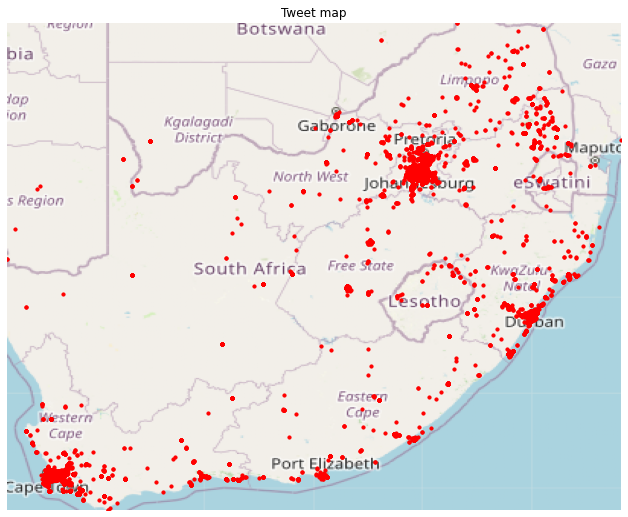

In [140]:
#Show the collected tweets on a map
places = []
for i in tweets['place']:
    try:
        places.append(i['coordinates'])
    except:
        continue

ruh_m = plt.imread('/Users/tomashegewisch/research_project/Tomas/data/map.png')
map_points = pd.DataFrame(places)
map_points.columns = ['latitude', 'longitude']

#Latitude: -28.4793 Longitude: 24.6727.

fig, ax = plt.subplots(figsize = (11,10))
ax.scatter(map_points.longitude, map_points.latitude, zorder=1, alpha= 1, c='red', s=10)

BBox = ((map_points.longitude.min(),   map_points.longitude.max(),      
         map_points.latitude.min(), map_points.latitude.max()))
#print(BBox)
ax.set_title('Tweet map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.axis("off") 
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/tweet_Map.png")

85560
76461


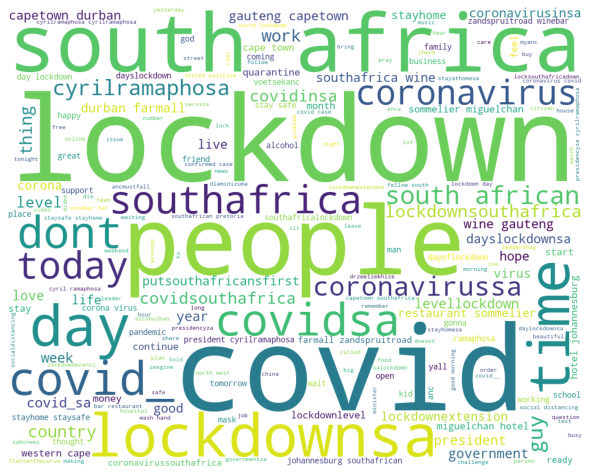

In [141]:
#word Cloud all words... no hash tags .. no mentions
from wordcloud import WordCloud, STOPWORDS 
hashtags = []
# #create a list of hashtages
for i in tweets['hashtags']:
    for j in i:
        hashtags.append(j.lower())
        
mentions = []
for i in tweets['mentions']:
    for j in i:
        mentions.append(j['screen_name'].lower())

x = set(word_list[0].tolist())
y = set(hashtags)
x.difference_update(y)
cleaned_words_no_hashtags = list(x)

x2 = set(cleaned_words_no_hashtags)
print(len(x2))
y2 = set(mentions)
x2.difference_update(y2)
print(len(x2))
cleaned_words_no_hashtags = list(x2)

text=" ".join(cleaned_words_no_hashtags)
text=" ".join(word_list[0].tolist())

wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(text)
wordcloud.to_file("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/All_words.png")
#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()
#plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/All_words.png")

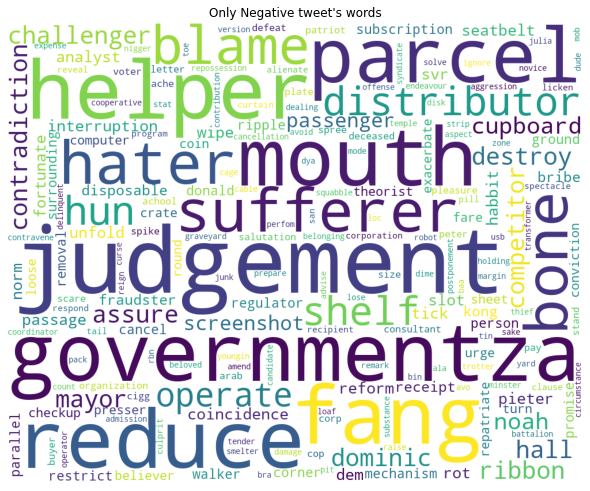

In [21]:
# word cloud with negitive sentimnet tweets.
negitive_tweets_words_list = []

for i in range(0, len(tweets)):
    try:
        if tweets['senti_values'][i] < 0:
            for j in tweets['tokenised'][i]:
                negitive_tweets_words_list.append(j)
    except:
        continue

x = set(negitive_tweets_words_list)
y = set(hashtags)
x.difference_update(y)
negitve_words_no_hashtags = list(x)

#cleaned_words_no_hashtags_negitive

text = " ".join(negitve_words_no_hashtags)
wordcloud = WordCloud(width = 1000, height = 800, 
               background_color ='white',  
               min_font_size = 12).generate(text)  
#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Only Negative tweet's words", size = 12, color = "black")
plt.tight_layout(pad = 0)
plt.show()
wordcloud.to_file("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/negitive_words.png")
#plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/negitive_words.png")

611298
462300


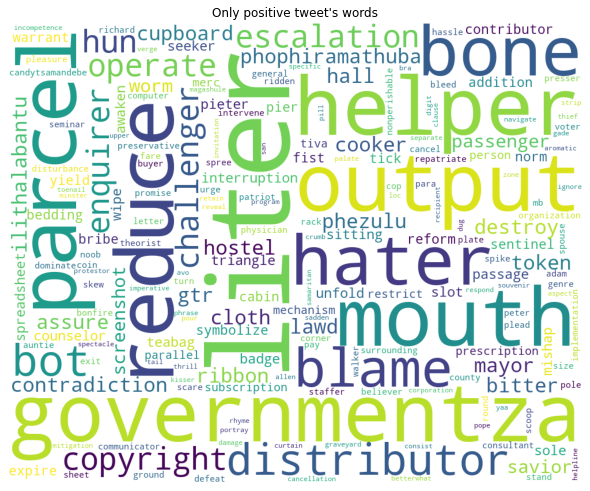

In [142]:
# word cloud with negitive positive tweets.
positive_tweets_words_list = []
for i in range(0, len(tweets)):
    try:
        if tweets['senti_values'][i] > 0:
            for j in tweets['tokenised'][i]:
                positive_tweets_words_list.append(j)
    except Exception as e:
        continue
print(len(positive_tweets_words_list))
print(len(hashtags))
x1 = set(positive_tweets_words_list)
y1 = set(hashtags)
x1.difference_update(y1)

text = " ".join(list(x1))

wordcloud = WordCloud(width = 1000, height = 800, 
               background_color ='white',  
               min_font_size = 12).generate(text)  
#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Only positive tweet's words", size = 12, color = "black")
plt.tight_layout(pad = 0)
plt.show()
wordcloud.to_file("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/positive_words.png")
#plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/wordcloud/positive_words.png")

,date,size
0,next_day2,2
1,next_day,0


In [28]:
# How many times does this word appear
#word_list_counter
find_words = ["alcohol","cigarettes","ban","government", "ramaphosa", "cyril", "zwelini","mkhize"]
for i in find_words:
    print("The word: ", i, "was found", word_list_counter[i], "times")

The word:  alcohol was found 2901 times
The word:  cigarettes was found 795 times
The word:  ban was found 873 times
The word:  government was found 3005 times
The word:  ramaphosa was found 3653 times
The word:  cyril was found 1775 times
The word:  zwelini was found 1 times
The word:  mkhize was found 303 times


In [26]:
word_list_counter.most_common(10)

[('covid', 24796),
 ('lockdown', 19809),
 ('cyrilramaphosa', 17432),
 ('lockdownsa', 14719),
 ('southafrica', 12146),
 ('people', 11286),
 ('covidsa', 9981),
 ('south', 9648),
 ('coronavirussa', 9229),
 ('day', 9025)]

In [170]:
print("There are",len(tweets.user_id.unique().tolist()), "Unique users <user_id>")
print("There are",len(tweets.username.unique().tolist()), "Unique users <name>")
print("The difference between the values happens when someone changes their username")

There are 25831 Unique users <user_id>
There are 25835 Unique users <name>
The difference between the values happens when someone changes their username


In [182]:
print("Top 10 list of the most mentioned Twitter account\n")
for i in Counter([item["name"] for sublist in tweets['mentions'].tolist() for item in sublist]).most_common(10):
    print(i[0] ,i[1])

Top 10 list of the most mentioned Twitter account

cyril ramaphosa 🇿🇦 #staysafe 2713
presidency | south africa 🇿🇦 1906
african national congress 1113
dr zweli mkhize 947
south african government 848
department of health 477
minister of transport |mr fix 463
sa police service 🇿🇦 452
enca 388
visit south africa 309


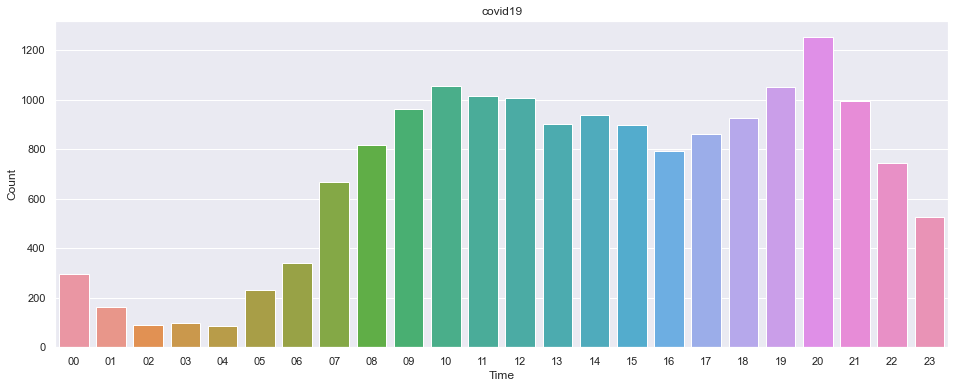

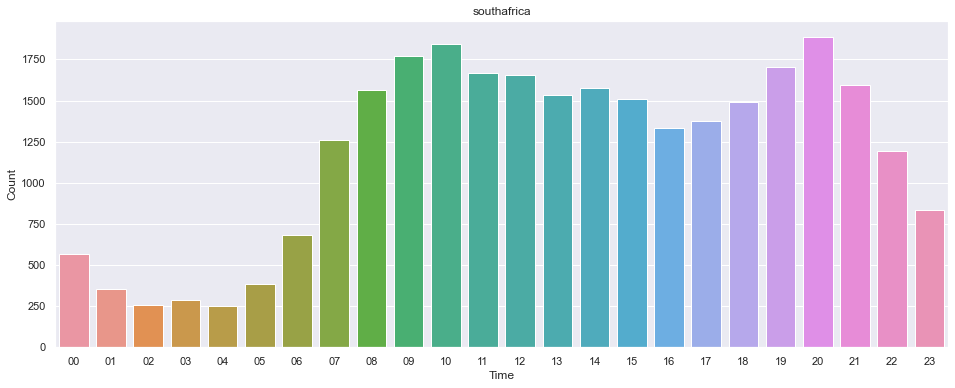

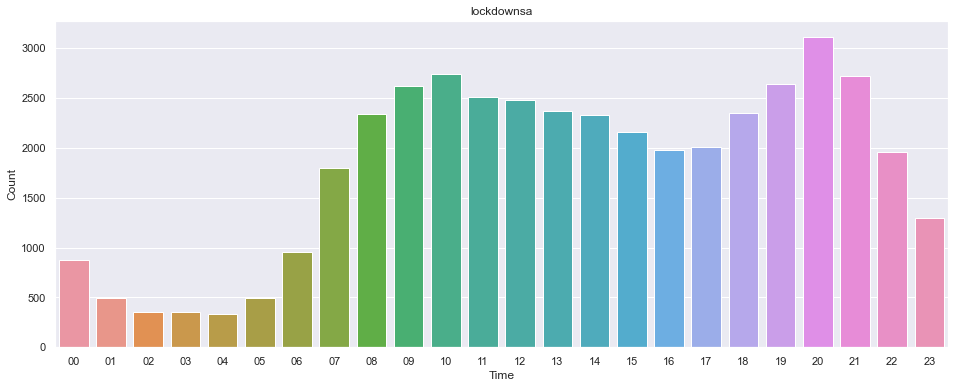

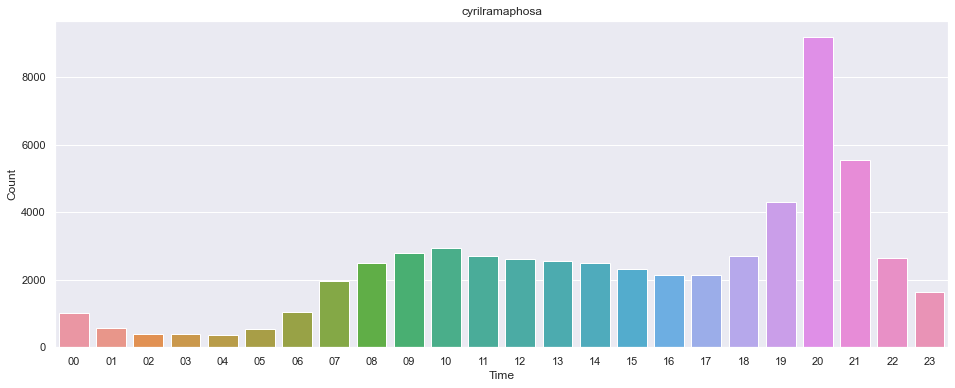

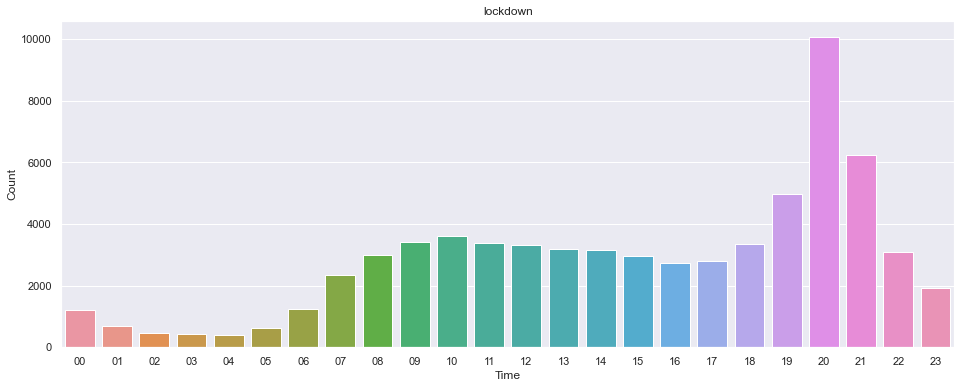

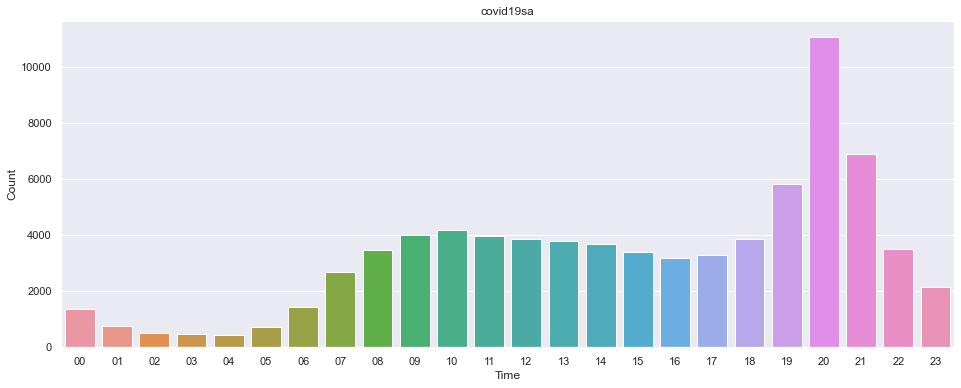

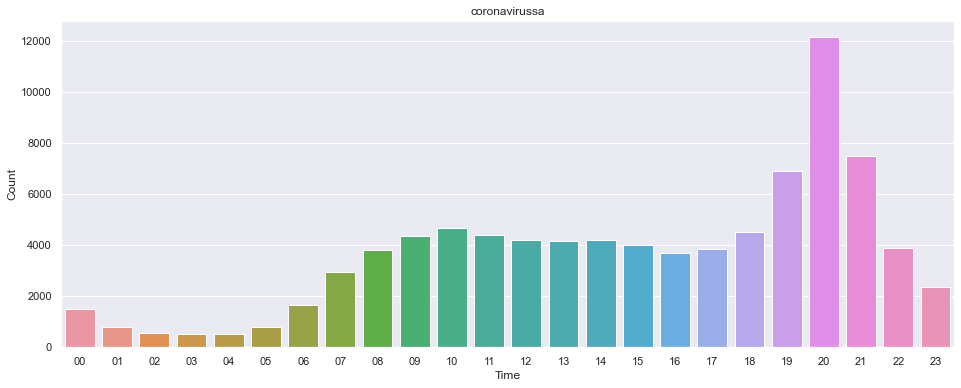

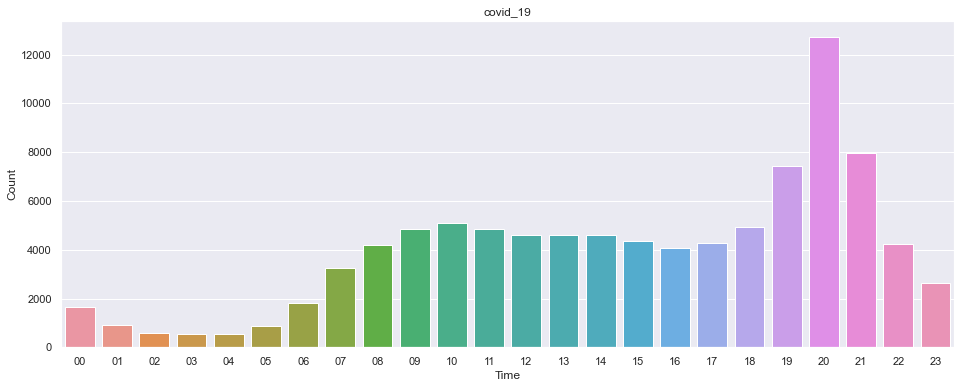

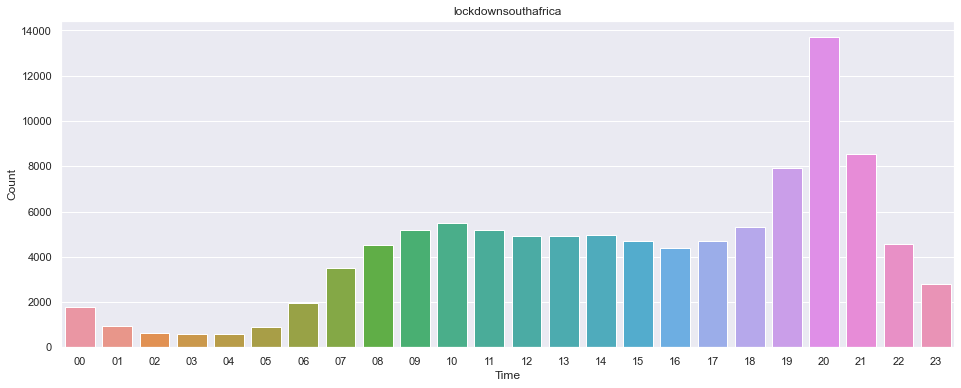

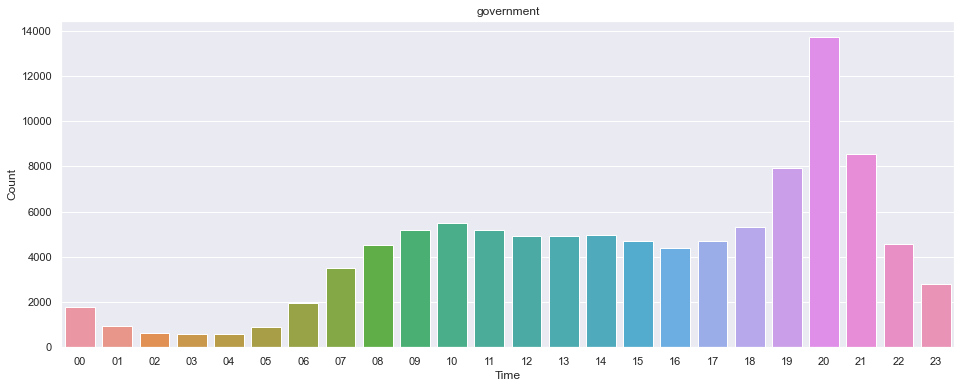

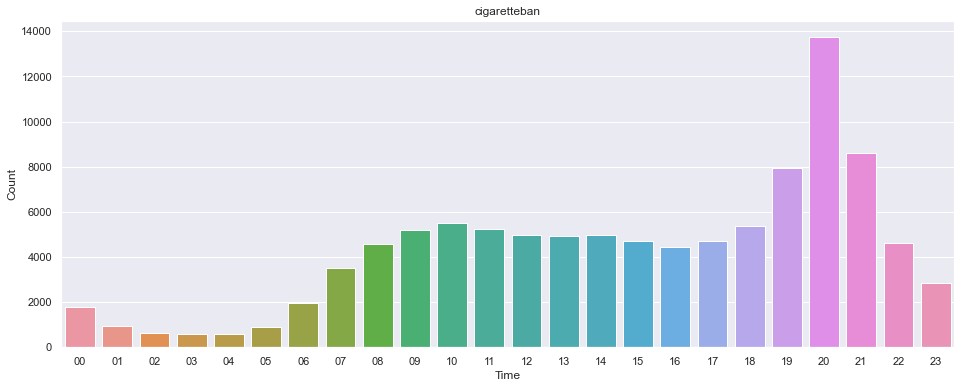

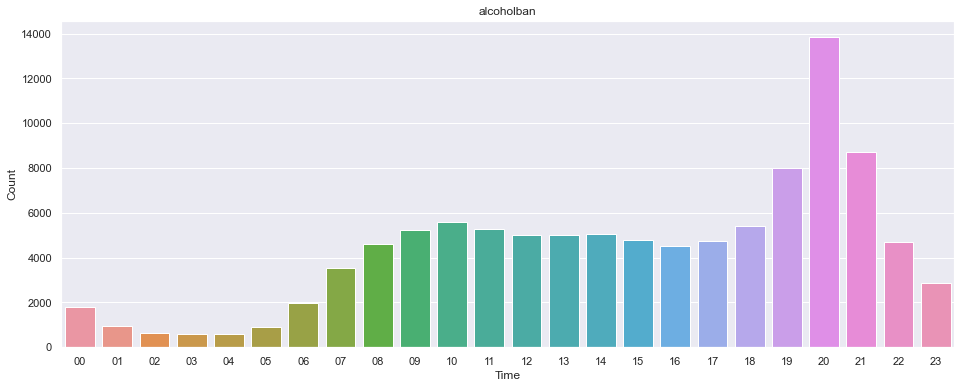

In [75]:
time_for_tweeting = []
def get_if_hastag(htags_list, find_word):
    for i in htags_list:
        if i == find_word:
            return True
    return False

def get_time_line(key_word):
    tweets_time = tweets[tweets['hashtags'].apply(lambda x : get_if_hastag(x,key_word)) == True]
    for i in tweets_time['time']:
        time_for_tweeting.append(i.split(":")[0])
    time_df = pd.DataFrame.from_dict((Counter(time_for_tweeting)), orient='index').reset_index()
    time_df = time_df.rename(columns={'index':'Time', 0:'Count'})
    time_df = time_df.sort_values(by=['Time']).reset_index().drop('index', axis=1)
    #sns.set_theme(style="darkgrid")
    plt.figure(figsize=(16, 6))
    ax = sns.barplot(x="Time", y="Count", data=time_df).set_title(key_word)
    plt.savefig("/Users/tomashegewisch/research_project/Tomas/charts/time_of_day/time_of_day_"+key_word+".png")
    plt.show()


list_of_hastages_to_process = ['covid19', 
'southafrica', 
'lockdownsa', 
'cyrilramaphosa', 
'lockdown', 
'covid19sa',
'coronavirussa',
'covid_19', 
'lockdownsouthafrica',
'government',
'cigaretteban', 
'alcoholban']

for i in list_of_hastages_to_process:
    get_time_line(i)

In [31]:
output = tweets[['id', 'tweet_clean']]
output.to_csv("/Users/tomashegewisch/Desktop/tweets_df.csv", index=False)